# Testing Notebook

This notebook provides some test code/ experimentation for the implementation of centrality analysis from the paper *On the Concept of Depth from Functional Data*

Warning: the work here is very rough.

The following function produces all subsequences of length `l` from the list `s`. 

In [1]:
from itertools import combinations 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

def subsequences(s, l):
    '''Returns a list of all possible subsequences of the given length from the given input list
    Parameters:
    -------------
    s: List to enumerate
    l: length of subsequences to find'''
    return sorted(set([i for i in combinations(s, l)]))

We now test the standard definition of $V(x_{i_1}, ... ,x_{i_j})$ containment in $\mathbb{R}^2$ 

And define a fake dataset to do so

In [2]:
df = pd.DataFrame([
    [1, 2, 3, 6, 9],
    [2, 4, 4, 7, 9],
    [3, 5, 4, 6.5, 12],
    [2, 6, 2, 6, 11],
    [1, 2, 1, 7, 11],
], columns=list('12345'))

df

,1,2,3,4,5
0,1,2,3,6.0,9
1,2,4,4,7.0,9
2,3,5,4,6.5,12
3,2,6,2,6.0,11
4,1,2,1,7.0,11


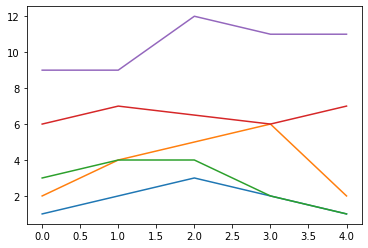

In [3]:
plt.plot(df);

In [5]:
from statdepth.depth import banddepth

banddepth([df], containment='r2', J=2)

KeyError: 0

We now test the closed form solution

In [ ]:
from scipy.special import comb

def banddepthclosed(data: pd.DataFrame, method='MBD'):
    n, p = data.shape
    rv = np.argsort(data, axis=0)
    rmat = np.argsort(rv, axis=0) + 1

    # This code is an explicit solution for J=2 and therefore cannot be generalized. 
    # band depth
    def _fbd2():
        down = np.min(rmat, axis=1) - 1
        up = n - np.max(rmat, axis=1)
        return (up * down + n - 1) / comb(n, 2)

    # modified band depth
    def _fmbd():
        down = rmat - 1
        up = n - rmat
        return ((np.sum(up * down, axis=1) / p) + n - 1) / comb(n, 2)

    if method == 'BD2':
        depth = _fbd2()
    elif method == 'MBD':
        depth = _fmbd()
    else:
        raise ValueError("Unknown input value for parameter `method`.")

    return depth

banddepthclosed(df)

We now redefine our band depth to use a modified definition for containment

In [8]:
def test(k='r2'):
    print('passed')

In [9]:
def test2(i: int):
    print('{} is '.format(i))

test(test2(123))

123 is 
passed
